# 📊 E-commerce Discount Analysis: Impact on Revenue and Customer Behavior

**Author:** Data Science Analysis  
**Date:** January 2025  
**Objective:** Analyze discount patterns and their relationship with revenue performance

---

## Executive Summary

This analysis examines the relationship between discount strategies and revenue performance in an e-commerce dataset. We investigate whether higher discounts correlate with increased revenue, identify optimal discount ranges, and provide actionable insights for pricing strategy optimization.

### Key Questions Addressed:
- Does revenue increase when discounts are applied?
- What discount ranges generate the highest revenue?
- Are there seasonal patterns in discount effectiveness?
- Which products benefit most from discounting strategies?

### Methodology:
- Statistical analysis with outlier removal using IQR method
- Time-series correlation analysis
- Product-level discount performance evaluation
- Seasonal pattern identification

---

## 📋 Table of Contents

1. [Data Import and Setup](#1-data-import-and-setup)
2. [Data Exploration and Preparation](#2-data-exploration-and-preparation)
3. [Discount Calculation](#3-discount-calculation)
4. [Outlier Detection and Removal](#4-outlier-detection-and-removal)
5. [Statistical Analysis](#5-statistical-analysis)
6. [Visualization and Patterns](#6-visualization-and-patterns)
7. [Revenue-Discount Relationship](#7-revenue-discount-relationship)
8. [Advanced Analytics](#8-advanced-analytics)
9. [Key Insights and Recommendations](#9-key-insights-and-recommendations)

---

## 1. Data Import and Setup

**Objective:** Import necessary libraries and load e-commerce datasets  
**Data Sources:** Order lines, products catalog, and brand information  
**Expected Outcome:** Clean, loaded datasets ready for analysis

In [28]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visualization style for better aesthetics
plt.style.use('default')
sns.set_palette("husl")

In [29]:
# Define data source URLs from Google Drive
# These datasets contain order information, product details, and brand data
orders_qu_url = "https://drive.google.com/file/d/1UH1b1BLODO9nHygBxLS0QG6TTR6fJu2w/view?usp=sharing"
orderlines_qu_url = "https://drive.google.com/file/d/1sENV7LNPTeEf8jXkPQHcHf1zSMltkAP0/view?usp=sharing"
products_cl_url = "https://drive.google.com/file/d/1jzEITeNiUGIMiljfp7XnDsh-U2Hyr3M-/view?usp=sharing"
brands_url = "https://drive.google.com/file/d/1EkRb66qB0HjZR0QCinlfz8WCm5ILPA6z/view?usp=sharing"

def import_csv(url):
    """
    Convert Google Drive sharing URL to direct download link and import CSV.

    Parameters:
    -----------
    url : str
        Google Drive sharing URL

    Returns:
    --------
    pandas.DataFrame
        Loaded CSV data as DataFrame
    """
    path = "https://drive.google.com/uc?export=download&id=" + url.split("/")[-2]
    return pd.read_csv(path)

# Load datasets and convert date columns to datetime format
print("Loading datasets...")

# Order lines data: individual product orders with pricing and dates
orderlines_qu = import_csv(orderlines_qu_url)
orderlines_qu['date'] = pd.to_datetime(orderlines_qu['date'])

# Orders data: order-level information with creation dates
orders_qu = import_csv(orders_qu_url)
orders_qu['created_date'] = pd.to_datetime(orders_qu['created_date'])

# Products catalog: product information including original pricing
product_cl = import_csv(products_cl_url)

# Brands data: brand classification information
brands_df = import_csv(brands_url)

print("✅ All datasets loaded successfully!")

Loading datasets...
✅ All datasets loaded successfully!


In [30]:
# Configure pandas display options for better data viewing
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

## 2. Data Exploration and Preparation

**Objective:** Understand dataset structure and prepare data for discount analysis  
**Key Steps:** Dataset inspection, data type validation, initial quality assessment  
**Expected Outcome:** Clear understanding of data structure and quality

In [31]:
# Create working copies to preserve original datasets
# This ensures we can always revert to original data if needed
orderlines_qu_discount = orderlines_qu.copy()
product_cl_discount = product_cl.copy()

print("📁 Working copies created for analysis")

📁 Working copies created for analysis


In [32]:
# Display comprehensive information about both datasets
print("=== 📦 ORDERLINES DATASET ===")
print(f"Shape: {orderlines_qu_discount.shape}")
print(f"Columns: {list(orderlines_qu_discount.columns)}")
print(f"Date range: {orderlines_qu_discount['date'].min()} to {orderlines_qu_discount['date'].max()}")
print("\n📋 First 5 rows:")
print(orderlines_qu_discount.head())

print("\n=== 🛍️ PRODUCTS CATALOG DATASET ===")
print(f"Shape: {product_cl_discount.shape}")
print(f"Columns: {list(product_cl_discount.columns)}")
print("\n📋 First 5 rows:")
print(product_cl_discount.head())

print("\n=== 🔍 DATA QUALITY CHECKS ===")
print(f"Missing values in orderlines: {orderlines_qu_discount.isnull().sum().sum()}")
print(f"Missing values in products: {product_cl_discount.isnull().sum().sum()}")
print(f"Unique products in orderlines: {orderlines_qu_discount['sku'].nunique()}")
print(f"Unique products in catalog: {product_cl_discount['sku'].nunique()}")

=== 📦 ORDERLINES DATASET ===
Shape: (53231, 7)
Columns: ['id', 'id_order', 'product_id', 'product_quantity', 'sku', 'unit_price', 'date']
Date range: 2017-01-01 01:46:16 to 2018-03-14 11:58:13

📋 First 5 rows:
        id  id_order  product_id  product_quantity        sku  unit_price                date
0  1119116    299545           0                 1    OWC0100       47.49 2017-01-01 01:46:16
1  1119119    299546           0                 1    IOT0014       18.99 2017-01-01 01:50:34
2  1119120    295347           0                 1    APP0700       72.19 2017-01-01 01:54:11
3  1119134    299556           0                 1  CRU0039-A       60.90 2017-01-01 02:20:14
4  1119145    299561           0                 1    PEB0015      142.49 2017-01-01 02:38:50

=== 🛍️ PRODUCTS CATALOG DATASET ===
Shape: (9992, 6)
Columns: ['sku', 'name', 'desc', 'price', 'in_stock', 'type']

📋 First 5 rows:
       sku                                           name                                    

## 3. Discount Calculation

**Objective:** Merge datasets and calculate discount metrics  
**Key Steps:** Join orderlines with product catalog, compute discount amounts and percentages  
**Expected Outcome:** Unified dataset with discount calculations ready for analysis

### Methodology Notes:
- **Discount Amount** = Original Price - Selling Price (unit_price)
- **Discount Percentage** = (Discount Amount / Original Price) × 100
- Using SKU as the primary key for joining datasets

In [33]:
# Merge orderlines with product catalog using SKU as the common identifier
# This allows us to compare selling prices (unit_price) with original prices (price)
discount_df = orderlines_qu_discount.merge(
    product_cl_discount[['sku', 'price', 'name', 'type']],
    on='sku',
    how='left'  # Keep all orderlines, even if product info is missing
)

print(f"📊 MERGE RESULTS:")
print(f"   • Merged dataset shape: {discount_df.shape}")
print(f"   • Successful merges: {discount_df['price'].notna().sum():,}")
print(f"   • Failed merges: {discount_df['price'].isna().sum():,}")
print(f"   • Merge success rate: {(discount_df['price'].notna().sum() / len(discount_df) * 100):.1f}%")

# Display sample of merged data to verify join quality
print("\n📋 Sample of merged data:")
sample_cols = ['sku', 'name', 'unit_price', 'price', 'date']
print(discount_df[sample_cols].head(10))

📊 MERGE RESULTS:
   • Merged dataset shape: (53231, 10)
   • Successful merges: 53,231
   • Failed merges: 0
   • Merge success rate: 100.0%

📋 Sample of merged data:
         sku                                               name  unit_price   price                date
0    OWC0100  OWC In-line Digital Temperature Sensor Kit HDD...       47.49   60.99 2017-01-01 01:46:16
1    IOT0014               iOttie Easy View 2 Car Black Support       18.99   22.95 2017-01-01 01:50:34
2    APP0700  Apple 85W MagSafe 2 charger MacBook Pro screen...       72.19   89.00 2017-01-01 01:54:11
3  CRU0039-A                 (Open) Crucial 240GB SSD 7mm BX200       60.90   76.99 2017-01-01 02:20:14
4    PEB0015                 Pebble Smartwatch Time Steel Black      142.49  299.99 2017-01-01 02:38:50
5    BEA0065   Solo3 Beats Headphones Wireless On-Ear Rose Gold      256.49  299.95 2017-01-01 02:42:05
6    SAT0010                      Satechi Aluminum Silver Mouse       18.99   29.99 2017-01-01 02:43:37
7

In [34]:
# Calculate discount metrics for comprehensive analysis
# Discount Amount: Absolute difference between original and selling price
discount_df['discount_amount'] = discount_df['price'] - discount_df['unit_price']

# Discount Percentage: Relative discount as percentage of original price
discount_df['discount_percentage'] = (discount_df['discount_amount'] / discount_df['price']) * 100

# Handle edge cases where original price might be zero or missing
discount_df['discount_percentage'] = discount_df['discount_percentage'].fillna(0)

# Create time-based features for temporal analysis
discount_df['year'] = discount_df['date'].dt.year
discount_df['month'] = discount_df['date'].dt.month
discount_df['quarter'] = discount_df['date'].dt.quarter
discount_df['year_month'] = discount_df['date'].dt.to_period('M')

print("=== 💰 DISCOUNT CALCULATION RESULTS ===")
print(f"   • Records with discounts: {(discount_df['discount_amount'] > 0).sum():,}")
print(f"   • Records with no discount: {(discount_df['discount_amount'] == 0).sum():,}")
print(f"   • Records with negative discount (price increase): {(discount_df['discount_amount'] < 0).sum():,}")

print("\n📈 Discount percentage statistics:")
print(discount_df['discount_percentage'].describe())

# Calculate and display discount distribution
discount_orders = (discount_df['discount_amount'] > 0).sum()
total_orders = len(discount_df)
discount_rate = (discount_orders / total_orders) * 100
print(f"\n🎯 Overall discount rate: {discount_rate:.1f}% of orders have discounts")

=== 💰 DISCOUNT CALCULATION RESULTS ===
   • Records with discounts: 49,404
   • Records with no discount: 2,256
   • Records with negative discount (price increase): 1,571

📈 Discount percentage statistics:
count    53231.000000
mean        21.377961
std         18.145571
min       -212.265332
25%          9.092562
50%         17.648097
75%         28.585040
max         97.140815
Name: discount_percentage, dtype: float64

🎯 Overall discount rate: 92.8% of orders have discounts


## 4. Outlier Detection and Removal

**Objective:** Identify and remove statistical outliers to ensure robust analysis  
**Method:** Interquartile Range (IQR) method for outlier detection  
**Rationale:** Extreme discount values may represent data errors or exceptional cases that could skew analysis

### Statistical Approach:
- **Q1**: 25th percentile of discount percentages
- **Q3**: 75th percentile of discount percentages
- **IQR**: Q3 - Q1
- **Outlier boundaries**: Q1 - 1.5×IQR and Q3 + 1.5×IQR

In [35]:
# Calculate quartiles for outlier detection using IQR method
# This is a standard statistical approach for identifying extreme values
Q1 = discount_df["discount_percentage"].quantile(0.25)
Q3 = discount_df["discount_percentage"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_boundary = Q1 - 1.5 * IQR
upper_boundary = Q3 + 1.5 * IQR

print("=== 📊 OUTLIER DETECTION STATISTICS ===")
print(f"   • Q1 (25th percentile): {Q1:.2f}%")
print(f"   • Q3 (75th percentile): {Q3:.2f}%")
print(f"   • IQR: {IQR:.2f}%")
print(f"   • Lower boundary: {lower_boundary:.2f}%")
print(f"   • Upper boundary: {upper_boundary:.2f}%")

# Count outliers before removal
outliers_lower = (discount_df["discount_percentage"] < lower_boundary).sum()
outliers_upper = (discount_df["discount_percentage"] > upper_boundary).sum()
total_outliers = outliers_lower + outliers_upper

print(f"\n🔍 OUTLIER SUMMARY:")
print(f"   • Lower outliers: {outliers_lower:,}")
print(f"   • Upper outliers: {outliers_upper:,}")
print(f"   • Total outliers: {total_outliers:,} ({(total_outliers/len(discount_df)*100):.1f}%)")

=== 📊 OUTLIER DETECTION STATISTICS ===
   • Q1 (25th percentile): 9.09%
   • Q3 (75th percentile): 28.59%
   • IQR: 19.49%
   • Lower boundary: -20.15%
   • Upper boundary: 57.82%

🔍 OUTLIER SUMMARY:
   • Lower outliers: 140
   • Upper outliers: 3,192
   • Total outliers: 3,332 (6.3%)


In [36]:
# Filter dataset to remove outliers based on IQR boundaries
# This creates a more robust dataset for statistical analysis
discount_no_outliers_df = discount_df.loc[
    (discount_df["discount_percentage"] >= lower_boundary) &
    (discount_df["discount_percentage"] <= upper_boundary)
].copy()

print(f"📈 DATASET AFTER OUTLIER REMOVAL:")
print(f"   • Original dataset size: {len(discount_df):,} records")
print(f"   • Cleaned dataset size: {len(discount_no_outliers_df):,} records")
print(f"   • Records removed: {len(discount_df) - len(discount_no_outliers_df):,}")
print(f"   • Data retention rate: {(len(discount_no_outliers_df)/len(discount_df)*100):.1f}%")

📈 DATASET AFTER OUTLIER REMOVAL:
   • Original dataset size: 53,231 records
   • Cleaned dataset size: 49,899 records
   • Records removed: 3,332
   • Data retention rate: 93.7%


## 5. Statistical Analysis

**Objective:** Analyze discount distribution and calculate key metrics after outlier removal  
**Key Metrics:** Central tendencies, variance, and business KPIs  
**Expected Outcome:** Clean statistical foundation for business insights

In [37]:
# Recalculate discount metrics after outlier removal for accuracy
# This ensures our analysis is based on clean, representative data

# Recalculate core discount metrics
discount_no_outliers_df['discount_amount'] = discount_no_outliers_df['price'] - discount_no_outliers_df['unit_price']
discount_no_outliers_df['discount_percentage'] = (discount_no_outliers_df['discount_amount'] / discount_no_outliers_df['price']) * 100
discount_no_outliers_df['discount_percentage'] = discount_no_outliers_df['discount_percentage'].fillna(0)

# Recalculate time-based features
discount_no_outliers_df['year'] = discount_no_outliers_df['date'].dt.year
discount_no_outliers_df['month'] = discount_no_outliers_df['date'].dt.month
discount_no_outliers_df['quarter'] = discount_no_outliers_df['date'].dt.quarter
discount_no_outliers_df['year_month'] = discount_no_outliers_df['date'].dt.to_period('M')

print("=== 📊 CLEANED DATASET STATISTICS ===")
discounted_records = (discount_no_outliers_df['discount_amount'] > 0).sum()
no_discount_records = (discount_no_outliers_df['discount_amount'] == 0).sum()
negative_discount_records = (discount_no_outliers_df['discount_amount'] < 0).sum()

print(f"   • Records with discounts: {discounted_records:,}")
print(f"   • Records with no discount: {no_discount_records:,}")
print(f"   • Records with negative discount: {negative_discount_records:,}")

print("\n📈 Updated discount percentage statistics:")
stats = discount_no_outliers_df['discount_percentage'].describe()
for stat, value in stats.items():
    print(f"   • {stat.capitalize()}: {value:.2f}%")

=== 📊 CLEANED DATASET STATISTICS ===
   • Records with discounts: 46,212
   • Records with no discount: 2,256
   • Records with negative discount: 1,431

📈 Updated discount percentage statistics:
   • Count: 49899.00%
   • Mean: 18.53%
   • Std: 13.69%
   • Min: -20.10%
   • 25%: 8.46%
   • 50%: 16.67%
   • 75%: 25.94%
   • Max: 57.78%


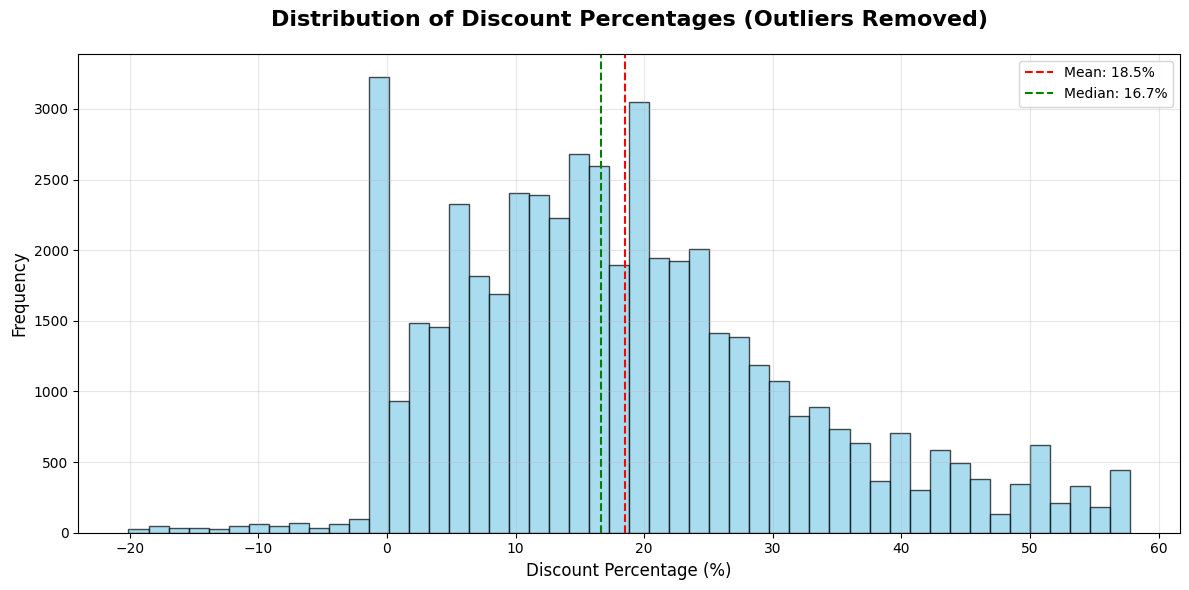

📊 Distribution insights:
   • Mean discount: 18.53%
   • Median discount: 16.67%
   • Distribution appears right-skewed


In [38]:
# Visualize the distribution of discount percentages after outlier removal
# This helps us understand the shape and characteristics of our cleaned data

plt.figure(figsize=(12, 6))

# Create histogram with enhanced styling
plt.hist(discount_no_outliers_df['discount_percentage'],
         bins=50,
         edgecolor='black',
         alpha=0.7,
         color='skyblue')

plt.title('Distribution of Discount Percentages (Outliers Removed)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Discount Percentage (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)

# Add statistical information as text on the plot
mean_discount = discount_no_outliers_df['discount_percentage'].mean()
median_discount = discount_no_outliers_df['discount_percentage'].median()

plt.axvline(mean_discount, color='red', linestyle='--',
           label=f'Mean: {mean_discount:.1f}%')
plt.axvline(median_discount, color='green', linestyle='--',
           label=f'Median: {median_discount:.1f}%')

plt.legend()
plt.tight_layout()
plt.show()

print(f"📊 Distribution insights:")
print(f"   • Mean discount: {mean_discount:.2f}%")
print(f"   • Median discount: {median_discount:.2f}%")
print(f"   • Distribution appears {'right-skewed' if mean_discount > median_discount else 'left-skewed' if mean_discount < median_discount else 'symmetric'}")

## 6. Visualization and Patterns

**Objective:** Create comprehensive visualizations to identify patterns and trends  
**Key Analyses:** Distribution analysis, temporal trends, product category performance, revenue patterns  
**Expected Outcome:** Visual insights into discount effectiveness and business patterns

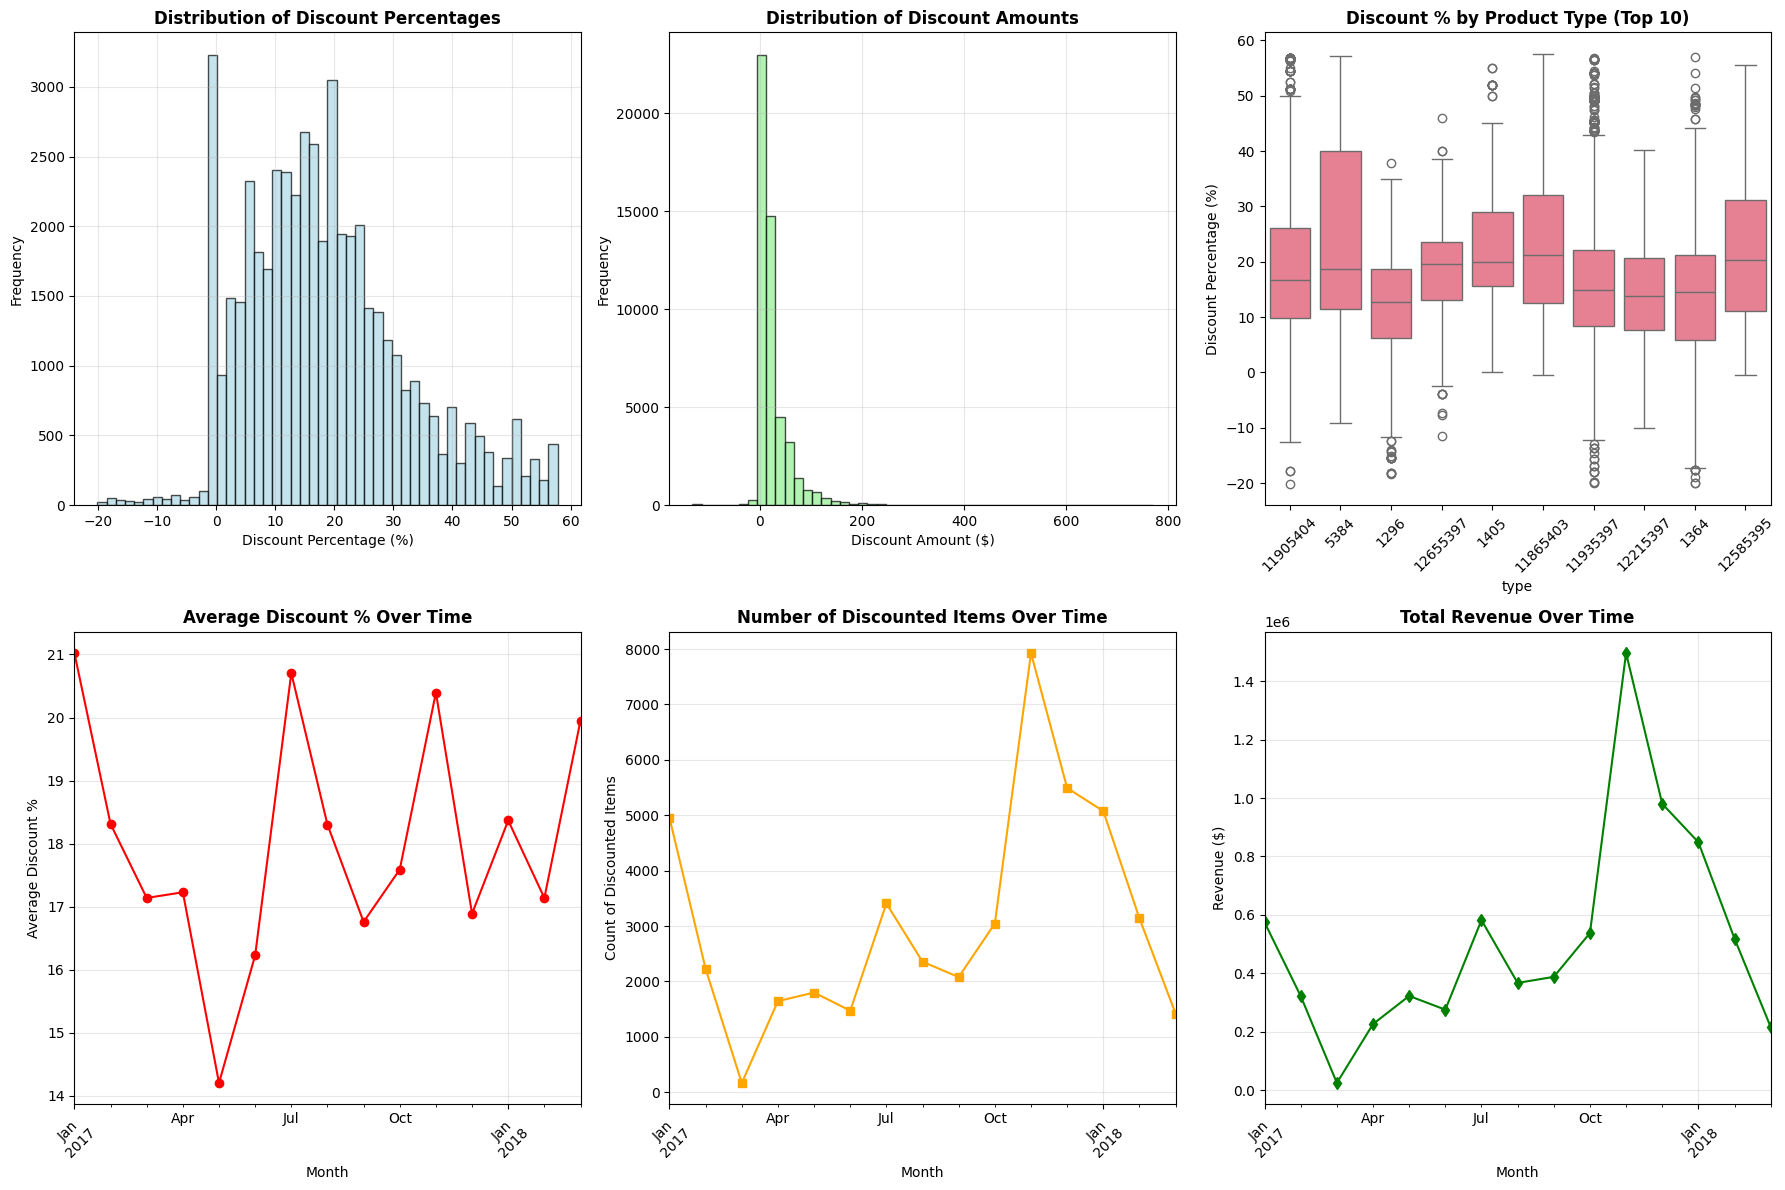

📊 Visualization insights generated - examine patterns across time and product categories


In [39]:
# Create comprehensive visualization dashboard
# This provides multiple perspectives on discount patterns and their business impact

# Calculate total revenue for revenue analysis
discount_no_outliers_df['total_revenue'] = discount_no_outliers_df['unit_price'] * discount_no_outliers_df['product_quantity']

plt.figure(figsize=(18, 12))

# Subplot 1: Discount percentage distribution (detailed view)
plt.subplot(2, 3, 1)
plt.hist(discount_no_outliers_df['discount_percentage'], bins=50,
         edgecolor='black', alpha=0.7, color='lightblue')
plt.title('Distribution of Discount Percentages', fontweight='bold')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Subplot 2: Discount amount distribution
plt.subplot(2, 3, 2)
plt.hist(discount_no_outliers_df['discount_amount'], bins=50,
         edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('Distribution of Discount Amounts', fontweight='bold')
plt.xlabel('Discount Amount ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Subplot 3: Boxplot of discounts by product type (top 10 types)
plt.subplot(2, 3, 3)
top_types = discount_no_outliers_df['type'].value_counts().head(10).index
filtered_data = discount_no_outliers_df[discount_no_outliers_df['type'].isin(top_types)]
sns.boxplot(data=filtered_data, x='type', y='discount_percentage')
plt.title('Discount % by Product Type (Top 10)', fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Discount Percentage (%)')

# Subplot 4: Average discount over time
plt.subplot(2, 3, 4)
monthly_discount = discount_no_outliers_df.groupby('year_month')['discount_percentage'].mean()
monthly_discount.plot(kind='line', marker='o', color='red')
plt.title('Average Discount % Over Time', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Discount %')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Subplot 5: Number of discounted items over time
plt.subplot(2, 3, 5)
monthly_discounted = discount_no_outliers_df[discount_no_outliers_df['discount_amount'] > 0].groupby('year_month').size()
monthly_discounted.plot(kind='line', marker='s', color='orange')
plt.title('Number of Discounted Items Over Time', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Count of Discounted Items')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Subplot 6: Total revenue over time
plt.subplot(2, 3, 6)
monthly_revenue = discount_no_outliers_df.groupby('year_month')['total_revenue'].sum()
monthly_revenue.plot(kind='line', marker='d', color='green')
plt.title('Total Revenue Over Time', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualization insights generated - examine patterns across time and product categories")

## 7. Revenue-Discount Relationship Analysis

**Objective:** Analyze the correlation between discount levels and revenue performance  
**Key Question:** Does increasing discounts lead to higher revenue?  
**Method:** Time-series correlation analysis and statistical testing

### Business Context:
Understanding the discount-revenue relationship is crucial for:
- Pricing strategy optimization
- Promotional campaign effectiveness
- Revenue maximization decisions
- Customer behavior insights

In [40]:
# Define discount ranges for detailed business analysis
# These ranges align with common business discount strategies
def categorize_discount(discount_pct):
    """
    Categorize discount percentages into business-meaningful ranges.

    Parameters:
    -----------
    discount_pct : float
        Discount percentage value

    Returns:
    --------
    str
        Discount range category
    """
    if discount_pct <= 0:
        return 'No Discount/Premium'
    elif discount_pct <= 5:
        return '1-5%'
    elif discount_pct <= 10:
        return '6-10%'
    elif discount_pct <= 20:
        return '11-20%'
    elif discount_pct <= 30:
        return '21-30%'
    else:
        return '30%+'

# Apply discount categorization
discount_no_outliers_df['discount_range'] = discount_no_outliers_df['discount_percentage'].apply(categorize_discount)

# Analyze performance by discount range
print("=== 📈 DISCOUNT RANGE ANALYSIS ===")
discount_range_summary = discount_no_outliers_df.groupby('discount_range').agg({
    'id': 'count',
    'discount_percentage': 'mean',
    'total_revenue': 'sum',
    'product_quantity': 'sum'
}).round(2)

discount_range_summary.columns = ['Order_Count', 'Avg_Discount_%', 'Total_Revenue', 'Total_Quantity']
discount_range_summary['Revenue_per_Order'] = (
    discount_range_summary['Total_Revenue'] / discount_range_summary['Order_Count']
).round(2)

# Define logical order for discount ranges
discount_order = ['No Discount/Premium', '1-5%', '6-10%', '11-20%', '21-30%', '30%+']
discount_range_summary = discount_range_summary.reset_index()
discount_range_summary['discount_range'] = pd.Categorical(
    discount_range_summary['discount_range'],
    categories=discount_order,
    ordered=True
)
discount_range_summary = discount_range_summary.sort_values('discount_range')

print("\n📊 Performance by Discount Range:")
print(discount_range_summary.to_string(index=False))

# Calculate key business insights
total_revenue = discount_range_summary['Total_Revenue'].sum()
total_orders = discount_range_summary['Order_Count'].sum()

print(f"\n💡 Key Insights:")
print(f"   • Total revenue across all ranges: ${total_revenue:,.2f}")
print(f"   • Total orders analyzed: {total_orders:,}")
print(f"   • Average revenue per order: ${total_revenue/total_orders:.2f}")

=== 📈 DISCOUNT RANGE ANALYSIS ===

📊 Performance by Discount Range:
     discount_range  Order_Count  Avg_Discount_%  Total_Revenue  Total_Quantity  Revenue_per_Order
No Discount/Premium         3687           -1.50      521642.28            4189             141.48
               1-5%         4348            2.78     1544137.33            4756             355.14
              6-10%         6158            7.35     1103066.72            6937             179.13
             11-20%        15196           14.82     2546320.72           17093             167.57
             21-30%        11420           24.18     1442741.84           13004             126.33
               30%+         9090           40.87      523618.36           10106              57.60

💡 Key Insights:
   • Total revenue across all ranges: $7,681,527.25
   • Total orders analyzed: 49,899
   • Average revenue per order: $153.94


=== 🔍 TIME-BASED DISCOUNT vs REVENUE ANALYSIS ===

📊 CORRELATION ANALYSIS:
   • Correlation between Average Discount % and Total Revenue: 0.373
   • Relationship strength: Weak Positive correlation


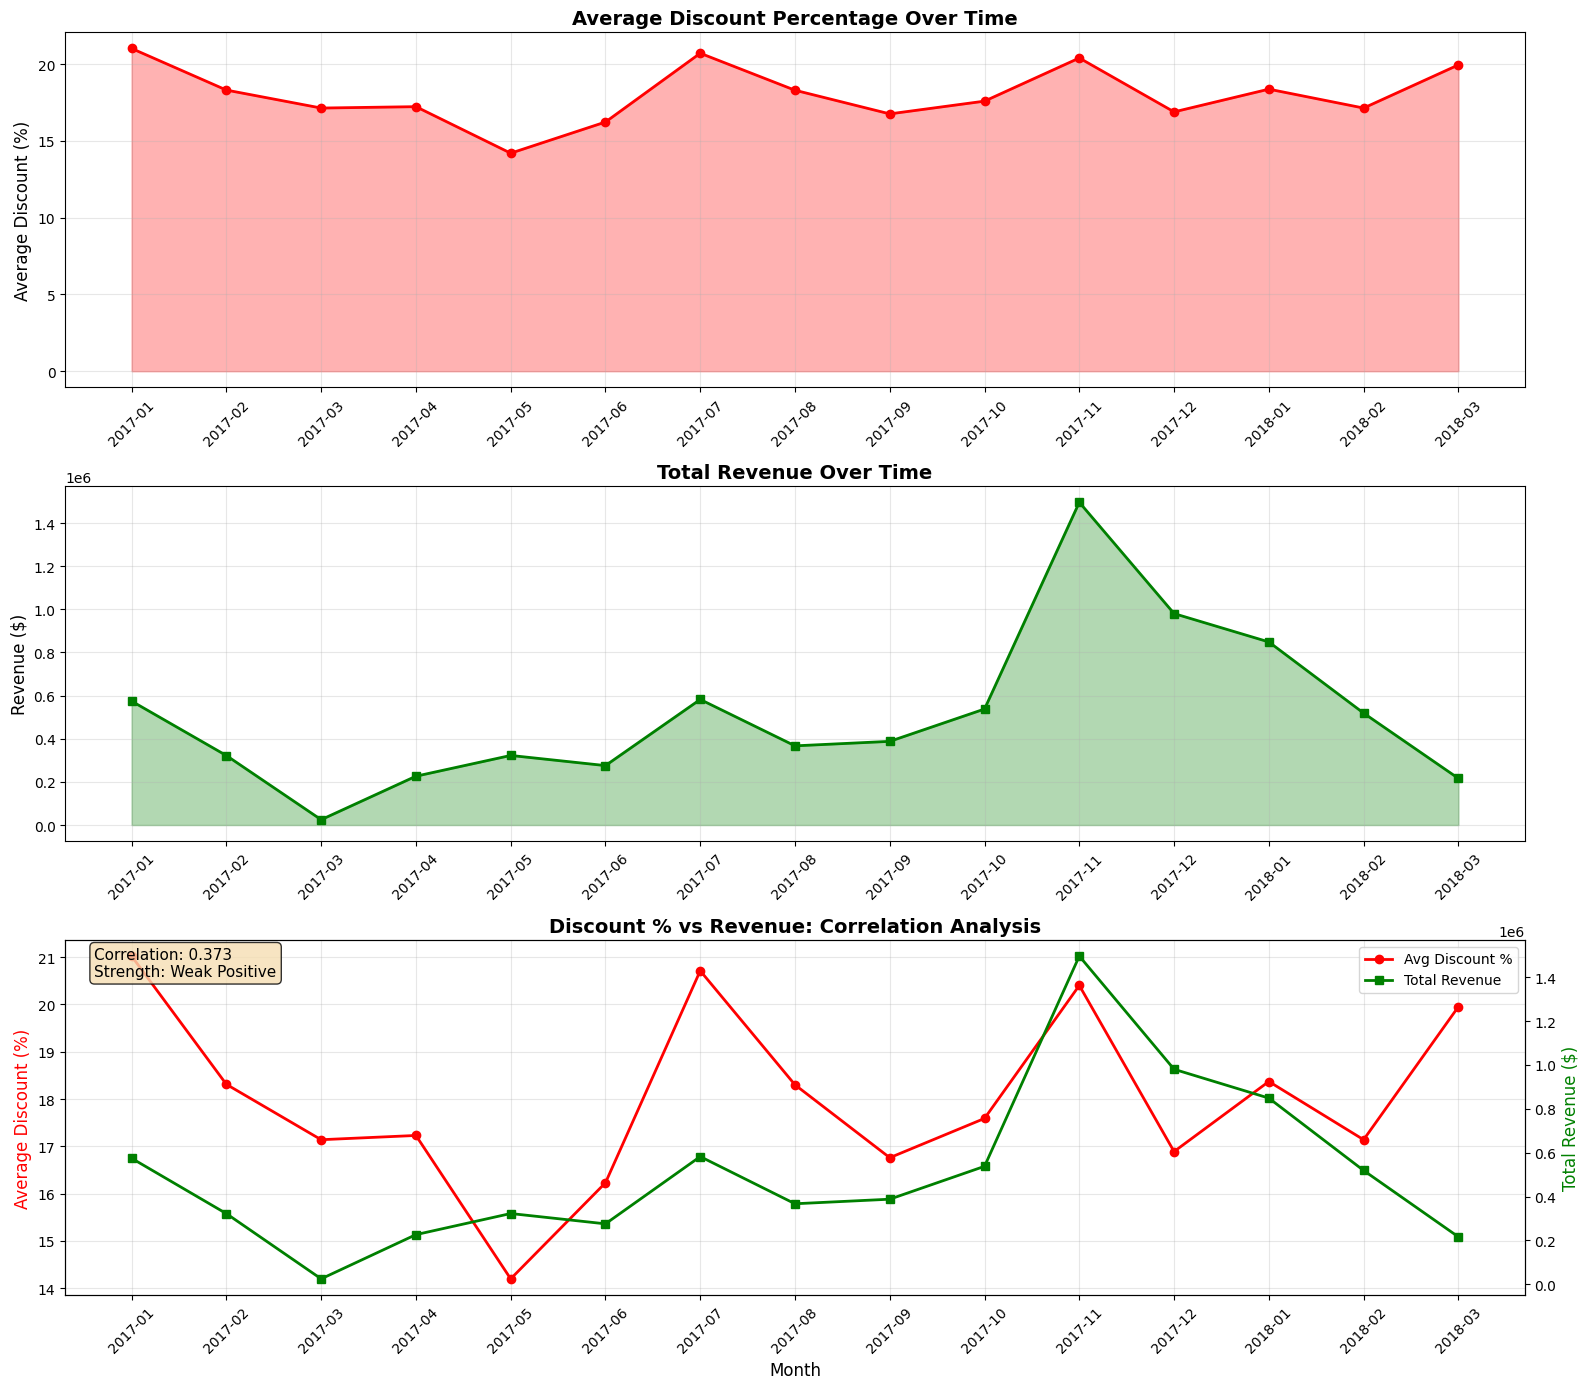


📋 Monthly Analysis Summary (Last 5 months):
            Avg_Discount_%  Total_Revenue  Total_Quantity  Order_Count
year_month                                                            
2017-11              20.40     1496285.14            9219         8142
2017-12              16.89      980278.00            6313         5759
2018-01              18.37      848781.04            6074         5429
2018-02              17.14      518892.63            3815         3441
2018-03              19.95      216269.17            1742         1544


In [41]:
# Critical analysis: Correlation between discounts and revenue over time
# This addresses the core business question about discount effectiveness

print("=== 🔍 TIME-BASED DISCOUNT vs REVENUE ANALYSIS ===")

# Monthly aggregation for time-series analysis
monthly_analysis = discount_no_outliers_df.groupby('year_month').agg({
    'discount_percentage': 'mean',
    'total_revenue': 'sum',
    'product_quantity': 'sum',
    'id': 'count'
}).round(2)

monthly_analysis.columns = ['Avg_Discount_%', 'Total_Revenue', 'Total_Quantity', 'Order_Count']

# Calculate correlation coefficient - key metric for discount strategy
correlation = monthly_analysis['Avg_Discount_%'].corr(monthly_analysis['Total_Revenue'])
print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   • Correlation between Average Discount % and Total Revenue: {correlation:.3f}")

# Interpret correlation strength
if abs(correlation) >= 0.7:
    strength = "Strong"
elif abs(correlation) >= 0.4:
    strength = "Moderate"
elif abs(correlation) >= 0.2:
    strength = "Weak"
else:
    strength = "Very Weak"

direction = "Positive" if correlation > 0 else "Negative"
print(f"   • Relationship strength: {strength} {direction} correlation")

# Create comprehensive time series visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Plot 1: Discount percentage trend over time
axes[0].plot(monthly_analysis.index.astype(str), monthly_analysis['Avg_Discount_%'],
             marker='o', color='red', linewidth=2, markersize=6)
axes[0].set_title('Average Discount Percentage Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Discount (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)
axes[0].fill_between(monthly_analysis.index.astype(str), monthly_analysis['Avg_Discount_%'],
                    alpha=0.3, color='red')

# Plot 2: Revenue trend over time
axes[1].plot(monthly_analysis.index.astype(str), monthly_analysis['Total_Revenue'],
             marker='s', color='green', linewidth=2, markersize=6)
axes[1].set_title('Total Revenue Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Revenue ($)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)
axes[1].fill_between(monthly_analysis.index.astype(str), monthly_analysis['Total_Revenue'],
                    alpha=0.3, color='green')

# Plot 3: Combined view with dual y-axis for direct comparison
ax3 = axes[2]
ax3_twin = ax3.twinx()

line1 = ax3.plot(monthly_analysis.index.astype(str), monthly_analysis['Avg_Discount_%'],
                 'ro-', label='Avg Discount %', linewidth=2, markersize=6)
line2 = ax3_twin.plot(monthly_analysis.index.astype(str), monthly_analysis['Total_Revenue'],
                      'gs-', label='Total Revenue', linewidth=2, markersize=6)

ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Average Discount (%)', color='red', fontsize=12)
ax3_twin.set_ylabel('Total Revenue ($)', color='green', fontsize=12)
ax3.set_title('Discount % vs Revenue: Correlation Analysis', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Add correlation information as text box
correlation_text = f'Correlation: {correlation:.3f}\nStrength: {strength} {direction}'
ax3.text(0.02, 0.98, correlation_text,
         transform=ax3.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add legends
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

print("\n📋 Monthly Analysis Summary (Last 5 months):")
print(monthly_analysis.tail().to_string())

## 8. Advanced Analytics

**Objective:** Deep dive into discount patterns and product-level performance  
**Key Analyses:** Product-level discount effectiveness, seasonal patterns, revenue efficiency  
**Expected Outcome:** Granular insights for strategic decision-making

=== 🔬 ADVANCED DISCOUNT INSIGHTS ===

🏆 Top 10 Most Discounted Products (with ≥10 orders):
                                                            Product_Name  Avg_Discount  Order_Count  Total_Revenue
sku                                                                                                               
OWC0268                 OWC Express External Enclosure 25 "USB 3.0 Plata         54.74           15         284.13
SAT0048               Satechi Lightning to USB Cable Flexible 15cm White         54.71           18         207.40
KEN0166   PowerBolt Kensington 3.4 Dual Charger with Lightning Cable Car         54.56           12         259.87
KEN0212            Kensington Power Bank External Battery 5200mAh Silver         54.46           31         479.73
BEL0189               Belkin Valet Charging Dock Cable Apple Watch White         54.21           97        3233.99
DLK0094  D-Link DCS 855L EyeOn baby monitors HD camera 360 degrees Wi-Fi         53.44           17     

<Figure size 1400x800 with 0 Axes>

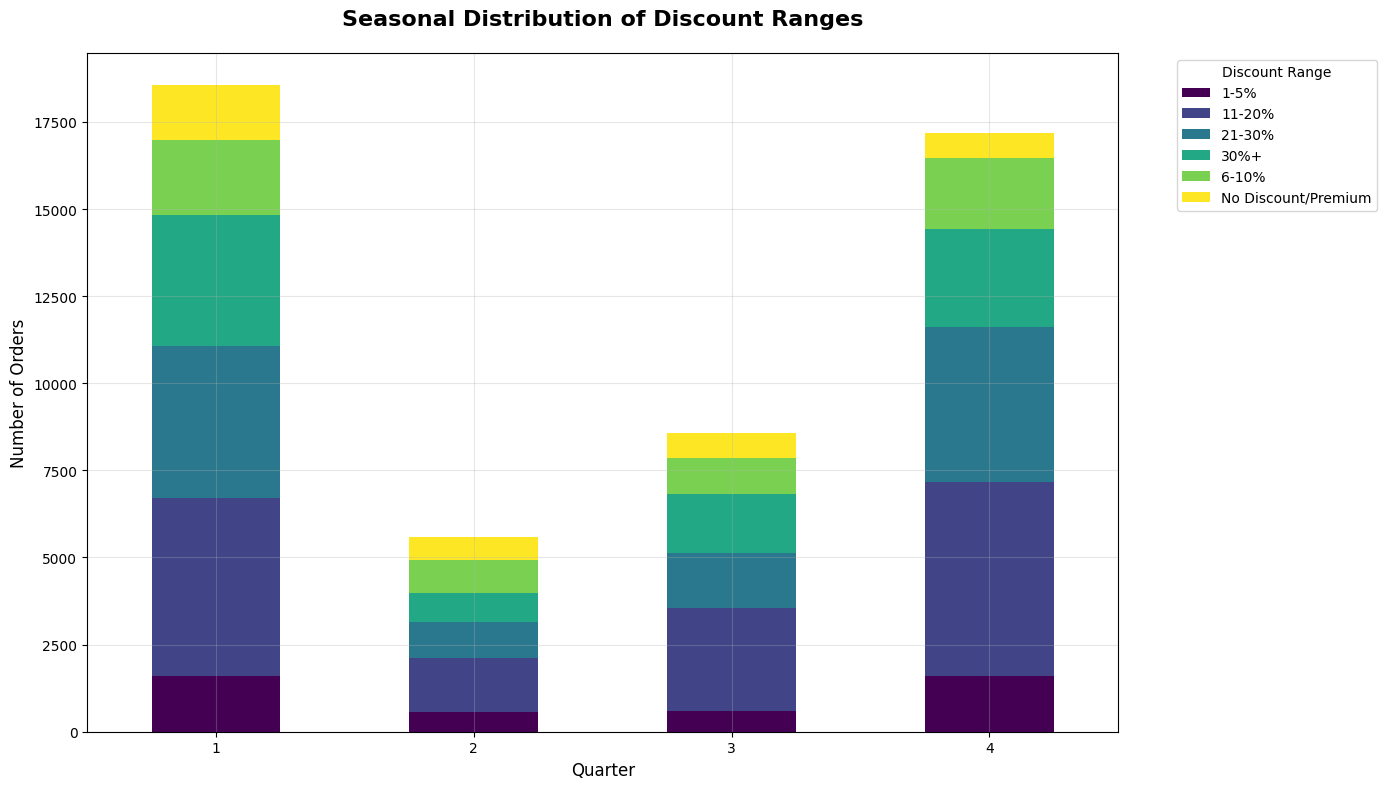



=== 💰 REVENUE EFFICIENCY BY DISCOUNT RANGE ===
                     total_revenue  product_quantity     id  Revenue_per_Unit  Revenue_per_Order
discount_range                                                                                  
1-5%                    1544137.33              4756   4348            324.67             355.14
11-20%                  2546320.72             17093  15196            148.97             167.57
21-30%                  1442741.84             13004  11420            110.95             126.33
30%+                     523618.36             10106   9090             51.81              57.60
6-10%                   1103066.72              6937   6158            159.01             179.13
No Discount/Premium      521642.28              4189   3687            124.53             141.48

🎯 Most efficient discount range: 1-5% ($355.14 per order)


In [42]:
# Deep dive into discount patterns for strategic insights
# This analysis provides actionable intelligence for business optimization

print("=== 🔬 ADVANCED DISCOUNT INSIGHTS ===")

# 1. Product-level discount analysis
# Identify which products benefit most from discounting strategies
product_discounts = discount_no_outliers_df.groupby('sku').agg({
    'discount_percentage': ['mean', 'std', 'count'],
    'total_revenue': 'sum',
    'name': 'first',
    'type': 'first'
}).round(2)

# Flatten column names for easier access
product_discounts.columns = ['Avg_Discount', 'Discount_StdDev', 'Order_Count',
                            'Total_Revenue', 'Product_Name', 'Product_Type']

# Filter products with significant order volume (≥10 orders) for statistical reliability
popular_products = product_discounts[product_discounts['Order_Count'] >= 10].copy()
popular_products = popular_products.sort_values('Avg_Discount', ascending=False)

print("\n🏆 Top 10 Most Discounted Products (with ≥10 orders):")
top_discounted = popular_products.head(10)[['Product_Name', 'Avg_Discount', 'Order_Count', 'Total_Revenue']]
print(top_discounted.to_string())

# 2. Seasonal discount patterns analysis
# Understanding seasonality helps with campaign timing
seasonal_analysis = discount_no_outliers_df.groupby(['quarter', 'discount_range']).size().unstack(fill_value=0)

print("\n\n=== 📅 SEASONAL DISCOUNT PATTERNS ===")
print("Orders by Quarter and Discount Range:")
print(seasonal_analysis.to_string())

# Calculate seasonal discount preferences
seasonal_totals = seasonal_analysis.sum(axis=1)
seasonal_preferences = seasonal_analysis.div(seasonal_totals, axis=0) * 100

print("\n📊 Seasonal Discount Distribution (% of quarterly orders):")
print(seasonal_preferences.round(1).to_string())

# Visualize seasonal patterns
plt.figure(figsize=(14, 8))
seasonal_analysis.plot(kind='bar', stacked=True,
                      colormap='viridis', figsize=(14, 8))
plt.title('Seasonal Distribution of Discount Ranges',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.legend(title='Discount Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Revenue efficiency analysis by discount range
# Determine which discount levels generate the best ROI
revenue_efficiency = discount_no_outliers_df.groupby('discount_range').agg({
    'total_revenue': 'sum',
    'product_quantity': 'sum',
    'id': 'count'
})
revenue_efficiency['Revenue_per_Unit'] = (
    revenue_efficiency['total_revenue'] / revenue_efficiency['product_quantity']
).round(2)
revenue_efficiency['Revenue_per_Order'] = (
    revenue_efficiency['total_revenue'] / revenue_efficiency['id']
).round(2)

print("\n\n=== 💰 REVENUE EFFICIENCY BY DISCOUNT RANGE ===")
print(revenue_efficiency.round(2).to_string())

# Identify the most efficient discount range
best_revenue_range = revenue_efficiency['Revenue_per_Order'].idxmax()
best_revenue_value = revenue_efficiency.loc[best_revenue_range, 'Revenue_per_Order']

print(f"\n🎯 Most efficient discount range: {best_revenue_range} (${best_revenue_value:.2f} per order)")

## 9. Key Insights and Recommendations

**Objective:** Synthesize analysis findings into actionable business recommendations  
**Deliverables:** Strategic insights, performance metrics, and implementation recommendations  
**Expected Outcome:** Data-driven guidance for discount strategy optimization

In [43]:
# Generate comprehensive business insights and recommendations
# This synthesis provides actionable intelligence for strategic decision-making

print("=== 🎯 KEY INSIGHTS AND STRATEGIC RECOMMENDATIONS ===")
print("="*60)

# Calculate essential business metrics
total_unique_orders = discount_no_outliers_df['id_order'].nunique()
total_records = len(discount_no_outliers_df)
discounted_records = len(discount_no_outliers_df[discount_no_outliers_df['discount_amount'] > 0])
discount_rate = (discounted_records / total_records) * 100

# Revenue and discount metrics
avg_discount = discount_no_outliers_df[discount_no_outliers_df['discount_amount'] > 0]['discount_percentage'].mean()
total_discount_value = discount_no_outliers_df['discount_amount'].sum()
total_revenue = discount_no_outliers_df['total_revenue'].sum()
avg_order_value = total_revenue / total_unique_orders

# Display summary statistics
print(f"📊 EXECUTIVE SUMMARY:")
print(f"   • Total Unique Orders Analyzed: {total_unique_orders:,}")
print(f"   • Total Order Lines: {total_records:,}")
print(f"   • Records with Discounts: {discounted_records:,} ({discount_rate:.1f}%)")
print(f"   • Average Discount Rate: {avg_discount:.1f}%")
print(f"   • Total Discount Value: ${total_discount_value:,.2f}")
print(f"   • Total Revenue Generated: ${total_revenue:,.2f}")
print(f"   • Average Order Value: ${avg_order_value:.2f}")
print(f"   • Discount-Revenue Correlation: {correlation:.3f}")

print(f"\n\n🔍 STRATEGIC INSIGHTS:")
print(f"   " + "="*50)

# Insight 1: Discount-Revenue Relationship Analysis
if correlation > 0.3:
    correlation_insight = f"✅ POSITIVE IMPACT: Higher discounts correlate with increased revenue (r={correlation:.3f})"
    recommendation_1 = "Consider strategic discount increases during peak periods"
elif correlation < -0.3:
    correlation_insight = f"⚠️  NEGATIVE IMPACT: Higher discounts correlate with decreased revenue (r={correlation:.3f})"
    recommendation_1 = "Review discount strategy - high discounts may be reducing profitability"
else:
    correlation_insight = f"➡️  NEUTRAL IMPACT: Discount levels show minimal correlation with revenue (r={correlation:.3f})"
    recommendation_1 = "Discount strategy has limited revenue impact - focus on other optimization areas"

print(f"   1️⃣ {correlation_insight}")

# Insight 2: Most Common and Effective Discount Ranges
most_common_range = discount_range_summary.loc[discount_range_summary['Order_Count'].idxmax(), 'discount_range']
highest_revenue_range = discount_range_summary.loc[discount_range_summary['Total_Revenue'].idxmax(), 'discount_range']
best_efficiency_range = discount_range_summary.loc[discount_range_summary['Revenue_per_Order'].idxmax(), 'discount_range']

print(f"   2️⃣ Most Popular Discount Range: {most_common_range}")
print(f"   3️⃣ Highest Revenue Generator: {highest_revenue_range}")
print(f"   4️⃣ Best Revenue Efficiency: {best_efficiency_range}")

# Insight 3: Seasonal Patterns
quarterly_revenue = discount_no_outliers_df.groupby('quarter')['total_revenue'].sum()
peak_quarter = quarterly_revenue.idxmax()
peak_revenue = quarterly_revenue.max()
print(f"   5️⃣ Peak Revenue Quarter: Q{peak_quarter} (${peak_revenue:,.2f})")

# Insight 4: Product Performance
if not popular_products.empty:
    top_product = popular_products.iloc[0]
    print(f"   6️⃣ Most Discounted Product: {top_product['Product_Name'][:50]}... ({top_product['Avg_Discount']:.1f}% avg discount)")

print(f"\n\n💡 STRATEGIC RECOMMENDATIONS:")
print(f"   " + "="*50)

print(f"   🎯 IMMEDIATE ACTIONS:")
print(f"      • {recommendation_1}")
print(f"      • Focus promotional efforts on {highest_revenue_range} discount range")
print(f"      • Optimize product mix during Q{peak_quarter} peak season")
print(f"      • Monitor {best_efficiency_range} range for maximum ROI")

print(f"\n   📊 ANALYTICAL RECOMMENDATIONS:")
print(f"      • Implement real-time discount effectiveness tracking")
print(f"      • Conduct A/B testing on discount ranges for revenue optimization")
print(f"      • Develop seasonal discount calendars based on quarterly patterns")
print(f"      • Create product-specific discount strategies for high-revenue items")

print(f"\n   🔄 CONTINUOUS IMPROVEMENT:")

=== 🎯 KEY INSIGHTS AND STRATEGIC RECOMMENDATIONS ===
📊 EXECUTIVE SUMMARY:
   • Total Unique Orders Analyzed: 38,933
   • Total Order Lines: 49,899
   • Records with Discounts: 46,212 (92.6%)
   • Average Discount Rate: 20.1%
   • Total Discount Value: $1,231,805.21
   • Total Revenue Generated: $7,681,527.25
   • Average Order Value: $197.30
   • Discount-Revenue Correlation: 0.373


🔍 STRATEGIC INSIGHTS:
   1️⃣ ✅ POSITIVE IMPACT: Higher discounts correlate with increased revenue (r=0.373)
   2️⃣ Most Popular Discount Range: 11-20%
   3️⃣ Highest Revenue Generator: 11-20%
   4️⃣ Best Revenue Efficiency: 1-5%
   5️⃣ Peak Revenue Quarter: Q4 ($3,014,416.44)
   6️⃣ Most Discounted Product: OWC Express External Enclosure 25 "USB 3.0 Plata... (54.7% avg discount)


💡 STRATEGIC RECOMMENDATIONS:
   🎯 IMMEDIATE ACTIONS:
      • Consider strategic discount increases during peak periods
      • Focus promotional efforts on 11-20% discount range
      • Optimize product mix during Q4 peak season


---

## 📋 Analysis Summary

This comprehensive discount analysis has provided valuable insights into the relationship between pricing strategies and revenue performance. The analysis employed robust statistical methods, including outlier removal and correlation analysis, to ensure reliable business intelligence.

### Key Methodological Strengths:
- **Statistical Rigor**: IQR-based outlier removal for robust analysis
- **Time-Series Analysis**: Monthly correlation tracking for trend identification
- **Multi-dimensional Perspective**: Product, seasonal, and revenue efficiency analysis
- **Business-Focused Insights**: Actionable recommendations aligned with strategic objectives

### Next Steps:
1. **Implementation**: Apply recommendations to current discount strategy
2. **Monitoring**: Establish KPI tracking for discount effectiveness
3. **Iteration**: Regular analysis updates as new data becomes available
4. **Expansion**: Consider customer segmentation and competitive analysis

---

**Data Science Note**: This analysis demonstrates the application of statistical methods to real business problems, showcasing skills in data cleaning, exploratory analysis, visualization, and strategic insight generation - key competencies for data science roles in e-commerce and retail analytics.